# Image Recognition - Classifying images from CIFAR-10 dataset

*Šimon Varga, Michal Barnišin*

The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images. They were collected by Alex Krizhevsky, Vinod Nair, and Geoffrey Hinton and are available [here](https://www.cs.toronto.edu/~kriz/cifar.html). 

### Loading data

In [25]:
import utils
import numpy as np

def load_all_data():
    all_images, all_labels = [], []
    for batch_nb in range(1, 6):
        imgs, labels = utils.read_data_batch(batch_nb)
        all_images.append(imgs)
        all_labels.append(labels)
    del imgs, labels
    all_images = np.concatenate(all_images, axis=0)
    all_labels = np.concatenate(all_labels, axis=0)
    return all_images, all_labels


train_data, train_labels = load_all_data()
test_data, test_labels = utils.read_test_batch()
labels = utils.read_meta()

## Exploratory data analysis

In [9]:
print(train_data.shape)
train_data

(50000, 3072)


array([[ 59,  43,  50, ..., 140,  84,  72],
       [154, 126, 105, ..., 139, 142, 144],
       [255, 253, 253, ...,  83,  83,  84],
       ...,
       [ 35,  40,  42, ...,  77,  66,  50],
       [189, 186, 185, ..., 169, 171, 171],
       [229, 236, 234, ..., 173, 162, 161]], dtype=uint8)

So we have 50,000 train images = rows, each row of the array stores a 32x32 colour image. The first 1024 entries contain the red channel values, the next 1024 the green, and the final 1024 the blue. The image is stored in row-major order, so that the first 32 entries of the array are the red channel values of the first row of the image.

In [8]:
train_labels

array([6, 9, 9, ..., 9, 1, 1])

Data are labeled with numbers in the range 0-9. The number at index i indicates the label of the ith image in the array data. The string representations of labels are:

In [15]:
for i in range(0, 1 + max(train_labels)):
    print(f"{i}\t{utils.get_label_name(i)}")

0	airplane
1	automobile
2	bird
3	cat
4	deer
5	dog
6	frog
7	horse
8	ship
9	truck


In [16]:
print(test_data.shape)
test_data

(10000, 3072)


array([[158, 159, 165, ..., 124, 129, 110],
       [235, 231, 232, ..., 178, 191, 199],
       [158, 158, 139, ...,   8,   3,   7],
       ...,
       [ 20,  19,  15, ...,  50,  53,  47],
       [ 25,  15,  23, ...,  80,  81,  80],
       [ 73,  98,  99, ...,  94,  58,  26]], dtype=uint8)

The test batch contains exactly 1000 randomly-selected images from each class.

Now, 9 random pictures follow, and 4 pictures from each category:

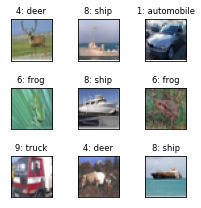

In [22]:
import matplotlib.pyplot as plt
import graphs

graphs.plot_random(train_data, train_labels, 3, 3,
            fontsize='small', sharey=True, sharex=True, figsize=(3, 3))
plt.tight_layout()
plt.show()

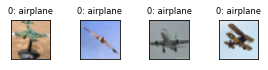

airplane: 5000 entries


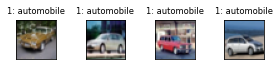

automobile: 5000 entries


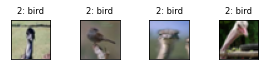

bird: 5000 entries


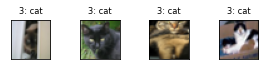

cat: 5000 entries


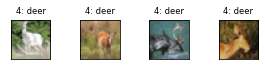

deer: 5000 entries


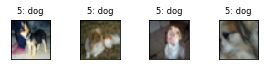

dog: 5000 entries


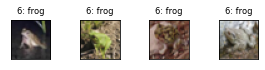

frog: 5000 entries


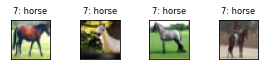

horse: 5000 entries


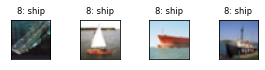

ship: 5000 entries


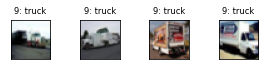

truck: 5000 entries


In [37]:
def imgs_of_cat(all_imgs, all_labels, cat):
    return np.array([all_imgs[i] for i in range(len(all_imgs)) 
                      if all_labels[i] == cat])


for i in range(len(labels)):
    label = labels[i].decode('utf-8')
    cat_images = imgs_of_cat(train_data, train_labels, i)
    graphs.plot_random(cat_images, [i] * len(cat_images), 1, 4,
                       fontsize='small', sharey=True, sharex=True,
                       figsize=(4, 1))
    plt.tight_layout()
    plt.show()
    print(f"{label}: {len(cat_images)} entries")
del cat_images

And average image for each category throughout the whole train set:

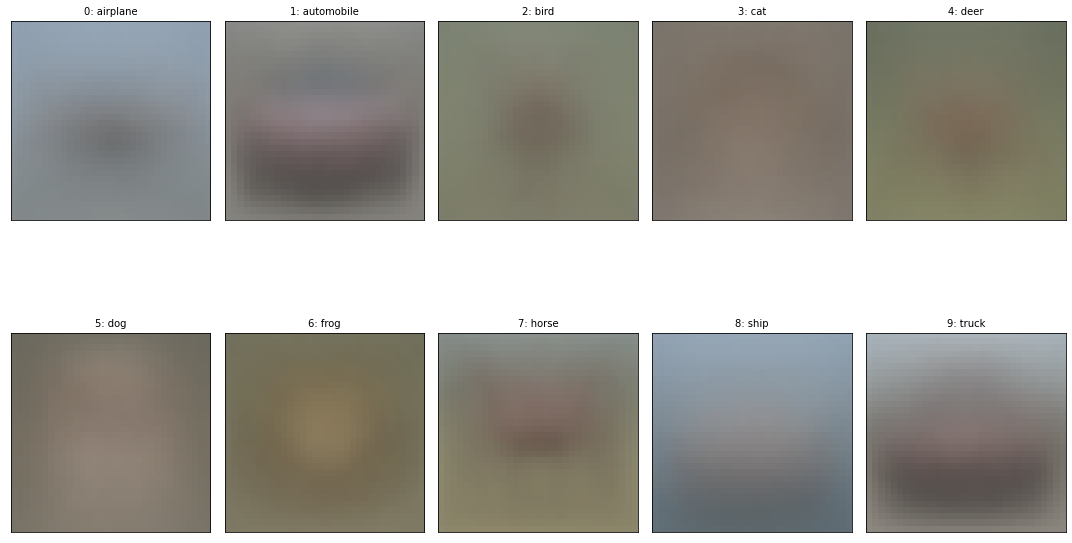

In [41]:
import EDA

batch = {
    b'data': train_data,
    b'labels': train_labels
}

EDA.plot_avg_imgs(batch, with_histogram=False)
plt.tight_layout()
plt.show()

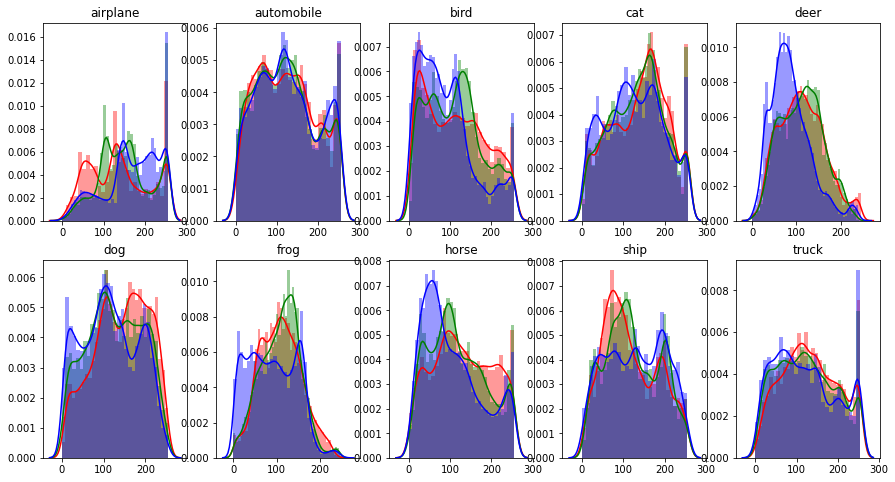

In [43]:
EDA.plot_global_hist(batch, sample_size=int(len(train_data) ** 0.25))

From which we can see...

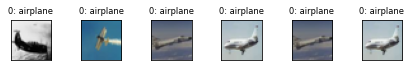

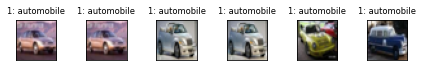

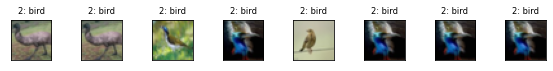

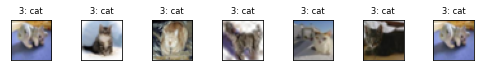

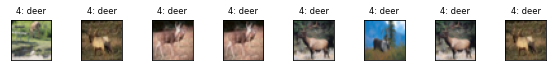

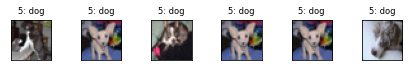

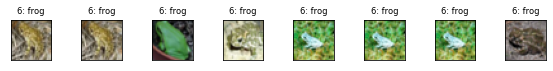

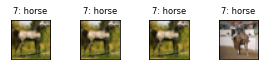

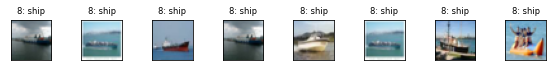

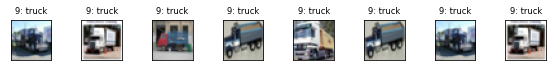

In [52]:
from sklearn.neighbors import LocalOutlierFactor


def detect_outliers(imgs, labels):
    # Take only subset of data
    sample = np.random.choice(len(imgs), 1000)
    imgs = imgs[sample]
    labels = labels[sample]
    
    # Scale data. For images it is simple, every pixel is in range 0-255.
    imgs = imgs / 255
    
    # Find Outliers using LOF
    LOF = LocalOutlierFactor()
    outliers = np.where(LOF.fit_predict(imgs) == -1)[0]
    
    for i in range(len(labels)):
        cat_images = imgs_of_cat(train_data[outliers], train_labels[outliers], i)
        if len(cat_images) == 0:
            continue
        graphs.plot_random(cat_images, [i] * len(cat_images), 1, len(cat_images),
                           fontsize='small', sharey=True, sharex=True,
                           figsize=(len(cat_images), 1))
        plt.tight_layout()
        plt.show()
        
detect_outliers(train_data, train_labels)

We have found out that there are also images with "unnatural" backgrouds.
For example clear white background.
Some histograms have large bin corresponding to RGB (255, 255, 255).